# Find out what data curation leads to expected eofs
- run whole existent data curation pipeline for few years and see if results as expected

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ERA5_DIR = ("/daten/reana/arch/reanalysis/reanalysis/DKRZ/IFS/" +
            "ERA5/day/atmos/zg/r1i1p1-050000Pa/")

files = [ERA5_DIR + f"zg_day_reanalysis_era5_r1i1p1-050000Pa_{y}0101-{y}1231.nc"
         for y in range(1950, 1953)]
ds_merged = xr.open_mfdataset(files, combine='by_coords')

ds_region = ds_merged.sel(lat=slice(20., 90.), lon=slice(250., 360.))
# ds_region = xr.concat(
#     [ds_merged.sel(lat=slice(20., 90.), lon=slice(250., 360.)),
#      ds_merged.sel(lat=slice(20., 90.), lon=0.)],
#     dim="lon"
# )

In [12]:
ds_region.info()

xarray.Dataset {
dimensions:
	time = 1096 ;
	lon = 391 ;
	bnds = 2 ;
	lat = 249 ;

variables:
	float64 lon_bnds(time, lon, bnds) ;
	float64 lat_bnds(time, lat, bnds) ;
	float32 zg(time, lat, lon) ;
		zg:standard_name = geopotential_height ;
		zg:long_name = Geopotential height ;
		zg:units = m ;
		zg:code = 129 ;
		zg:table = 128 ;
		zg:original_name = var129 ;
	datetime64[ns] time(time) ;
		time:standard_name = time ;
		time:axis = T ;
	float64 lon(lon) ;
		lon:standard_name = longitude ;
		lon:long_name = longitude ;
		lon:units = degrees_east ;
		lon:axis = X ;
		lon:bounds = lon_bnds ;
	float64 lat(lat) ;
		lat:standard_name = latitude ;
		lat:long_name = latitude ;
		lat:units = degrees_north ;
		lat:axis = Y ;
		lat:bounds = lat_bnds ;
	float64 plev() ;
		plev:standard_name = air_pressure ;
		plev:long_name = pressure ;
		plev:units = Pa ;
		plev:positive = down ;
		plev:axis = Z ;

// global attributes:
	:CDI = Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/cdi) ;
	:

In [2]:
class EOFer:
    def __init__(self, dataset, variable_name):
        """
        Initializes the EOFAnalysis class using xarray and sklearn PCA.

        Parameters:
        - dataset (xarray.Dataset): The dataset for EOF analysis.
        - variable_name (str): The name of the variable to analyze.
        """
        self.dataset = dataset
        self.variable_name = variable_name

        # Flatten data to 2D (time, space)
        self.data_array = self.dataset[self.variable_name].stack(space=[
                                                                 'lat', 'lon'])
        self.data_array = self.data_array.dropna('space', how='all')

        # Perform mean normalization over time
        self.data_mean = self.data_array.mean(dim='time')
        self.data_anom = self.data_array - self.data_mean

        # Fit PCA
        self.pca = PCA()
        self.pca.fit(self.data_anom.values)

        # Save results
        self.eigenvalues = self.pca.explained_variance_
        self.pcs = self.pca.transform(self.data_anom.values)
        self.eofs = xr.DataArray(self.pca.components_, dims=['mode', 'space'], coords={
                                 'mode': np.arange(1, self.pca.n_components_ + 1)})

    def plot_eigenvalues_and_pc_stds(self, num_modes=10):
        """
        Plots eigenvalues and standard deviations of principal components on a
        single scatter plot with two y-axes.

        Parameters:
        - num_modes (int): The number of modes to plot.
        """
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot eigenvalues on the primary y-axis
        ax1.plot(np.arange(1, num_modes + 1),
                 np.sqrt(self.eigenvalues[:num_modes]), 'o-', color='tab:blue', label='Eigenvalues')
        ax1.set_xlabel('Mode')
        ax1.set_ylabel('Eigenvalue', color='tab:blue')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.grid(True, which='both', axis='x')

        # Create secondary y-axis for standard deviations of PCs
        ax2 = ax1.twinx()
        pc_std_dev = np.std(self.pcs, axis=0)
        ax2.plot(np.arange(1, num_modes + 1),
                 pc_std_dev[:num_modes], 's-', color='tab:orange', label='PC Standard Deviation')
        ax2.set_ylabel('PC Standard Deviation', color='tab:orange')
        ax2.tick_params(axis='y', labelcolor='tab:orange')

        # Title and legend
        fig.suptitle(
            'Eigenvalues and Standard Deviation of Principal Components')
        fig.tight_layout()
        plt.show()

    def plot_eof(self, mode=1):
        """
        Plots a specified EOF mode as a map using an orthographic projection.

        Parameters:
        - mode (int): The mode number to plot (1-based index).
        """
        # Get the EOF mode (adjust for 0-based index)
        mode_index = mode - 1
        eof_mode_flat = self.eofs.isel(mode=mode_index)

        # Reshape EOF data to (lat, lon) dimensions
        eof_mode_reshaped = eof_mode_flat.values.reshape(
            self.dataset.dims['lat'], self.dataset.dims['lon']
        )

        # Create a plot with an orthographic projection
        fig, ax = plt.subplots(
            subplot_kw={'projection': ccrs.Orthographic(
                central_longitude=-45, central_latitude=45)},
            figsize=(12, 6))
        ax.set_global()

        # Plot EOF with contourf for better visual representation
        eof_plot = ax.contourf(
            self.dataset['lon'], self.dataset['lat'], eof_mode_reshaped,
            transform=ccrs.PlateCarree(), cmap='RdBu_r', extend='both'
        )

        # Add coastlines and gridlines for context
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, dms=True,
                     x_inline=False, y_inline=False)

        # Add color bar
        cbar = plt.colorbar(
            eof_plot, ax=ax, orientation='horizontal', pad=0.05)
        cbar.set_label('EOF Amplitude')

        plt.title(f'EOF Mode {mode}')
        plt.show()

## Check if symptom exists after clipping

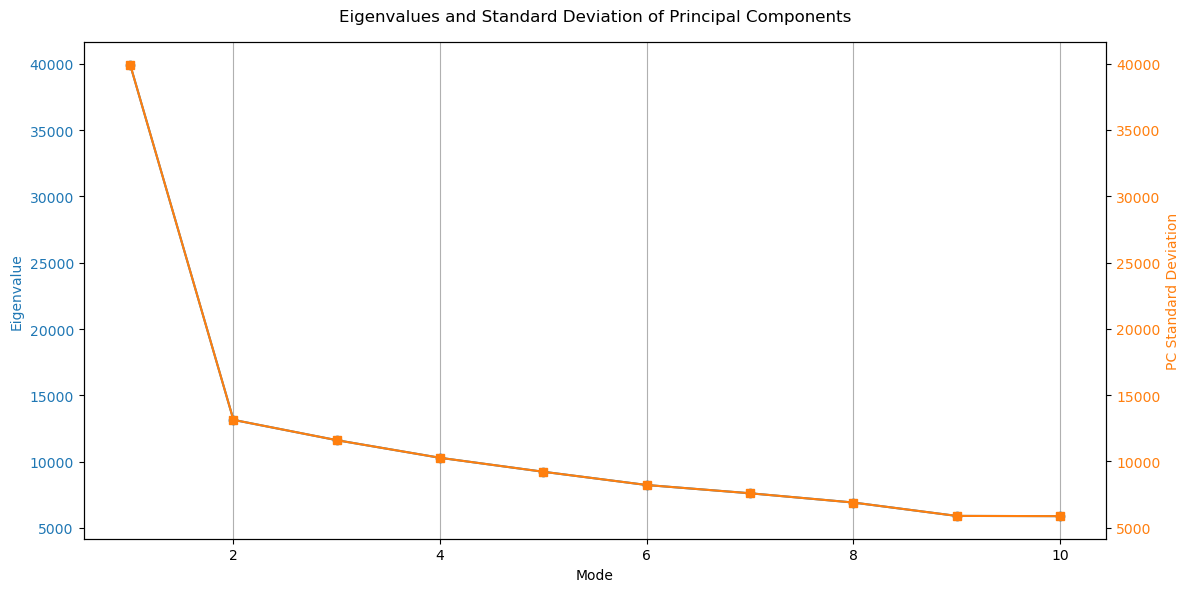

/tmp/ipykernel_71078/2752369428.py:77: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.dataset.dims['lat'], self.dataset.dims['lon']


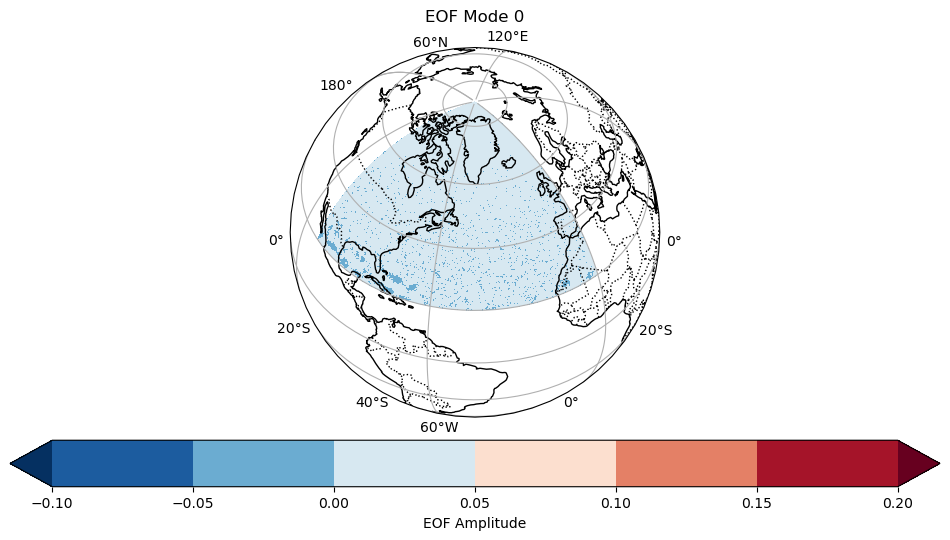

/tmp/ipykernel_71078/2752369428.py:77: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.dataset.dims['lat'], self.dataset.dims['lon']


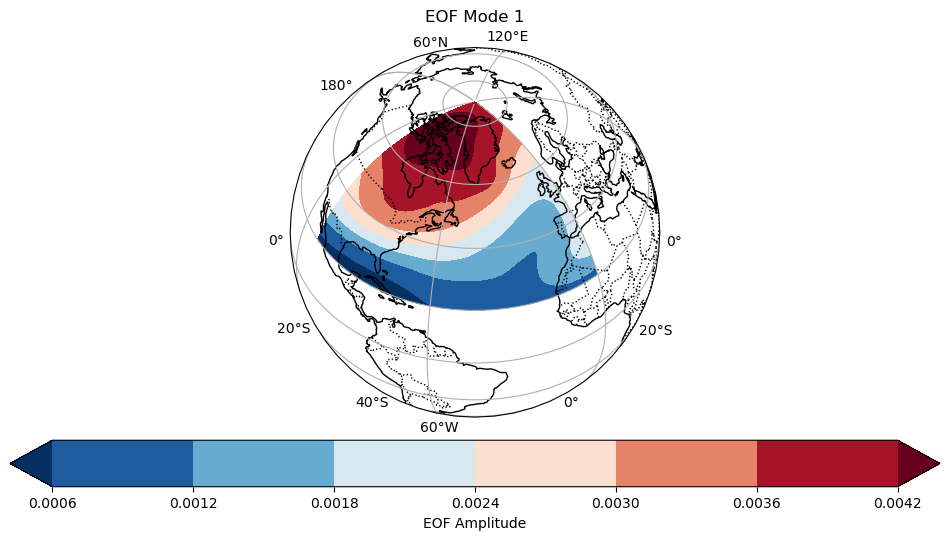

In [3]:
basic = EOFer(ds_region, 'zg')
basic.plot_eigenvalues_and_pc_stds()
basic.plot_eof(mode=0)
basic.plot_eof(mode=1)

## Check after it exists with anomalies

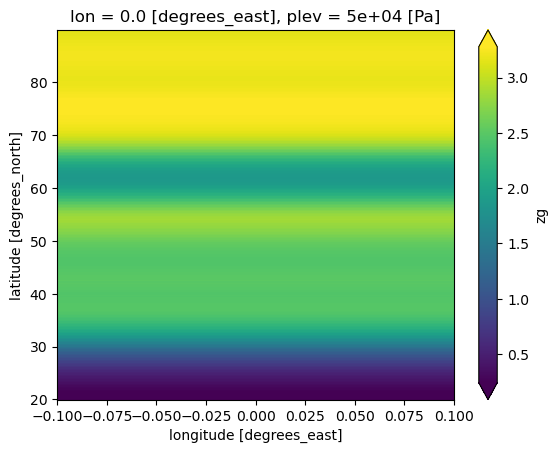

In [17]:
# Step 1: Calculate the daily mean climatology by grouping by 'dayofyear'
dayMean = ds_region["zg"].groupby("time.dayofyear").mean("time")

# Step 2: Pad the beginning and end of the dayMean to handle the rolling mean with periodic boundaries
dayMeanPadded = xr.concat(
    [dayMean[-45:], dayMean, dayMean[:45]], dim="dayofyear")

# Step 3: Apply a rolling mean over the extended 'dayofyear' climatology
rollingDayMean = dayMeanPadded.rolling(dayofyear=90, center=True).mean()

# Step 4: Trim the padding to get back to the original 365 days of the year
rollingDayMean = rollingDayMean.isel(dayofyear=slice(45, -45))

# Step 5: Reindex the rolling mean to match each day of the original dataset's time
# This will align 'dayofyear' from rollingDayMean with each date in ds_region
rollingDayMeanReindexed = rollingDayMean.sel(
    dayofyear=ds_region["time"].dt.dayofyear)

# Step 6: Calculate anomalies by subtracting the rolling mean from the original dataset
anos = ds_region.copy()
anos["zg"] = ds_region["zg"] - rollingDayMeanReindexed

anos_from_cdo = xr.open_dataset("../data/anos.nc")

sq_diff = (anos_from_cdo['zg'] - anos['zg'])**2
sq_diff = sq_diff.mean(dim="time")
sq_diff.plot.imshow(cmap='viridis', robust=True)

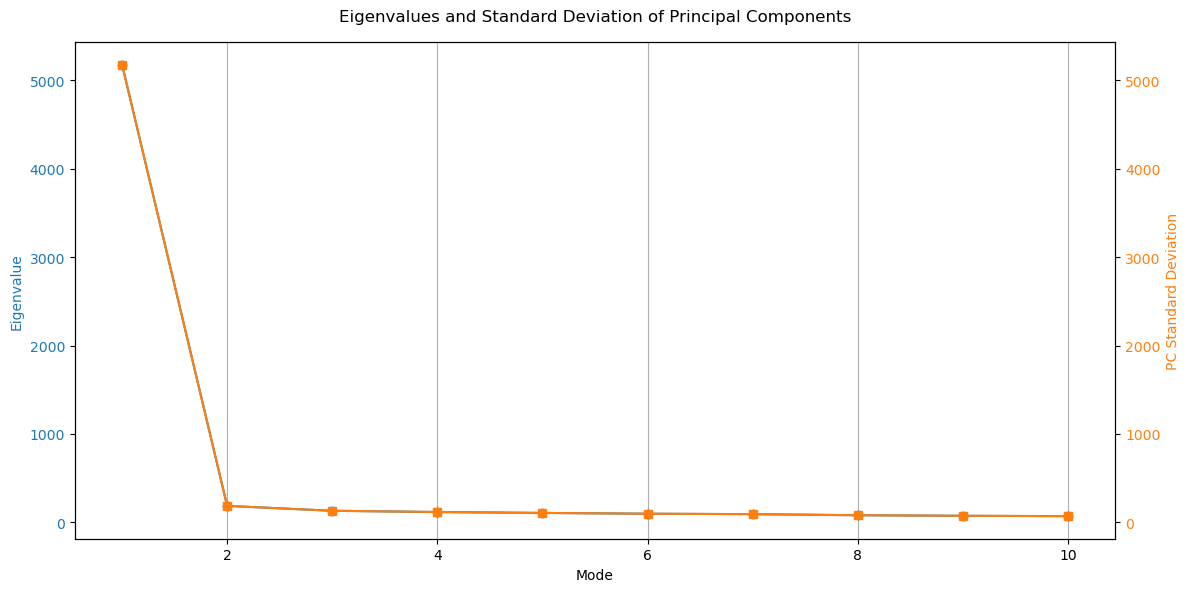

/tmp/ipykernel_21615/2752369428.py:77: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.dataset.dims['lat'], self.dataset.dims['lon']


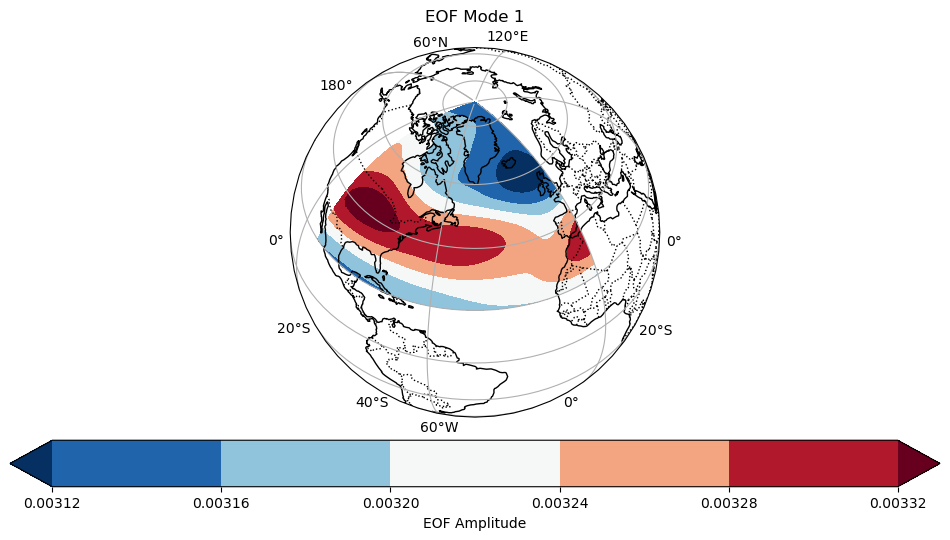

In [6]:
# Calculate the rolling standard deviation with a 30-day window, centered
rolling_std = ds_region['zg'].rolling(time=30, center=True).std()

# Calculate the mean of the rolling standard deviation across the spatial grid (field mean)
rolling_std_mean = rolling_std.mean(dim=['lat', 'lon'])

# Normalize the trimmed dataset by the enlarged (broadcasted) field mean of the rolling std

normalized_ds = ds_region.sel(time=slice(ds_region['time'].isel(time=15),
                                         ds_region['time'].isel(time=-15)))
normalized_ds['zg'] = ds_region['zg'] / rolling_std_mean

normal = EOFer(normalized_ds, 'zg')
normal.plot_eigenvalues_and_pc_stds()
normal.plot_eof(mode=1)

## Same with anomalies

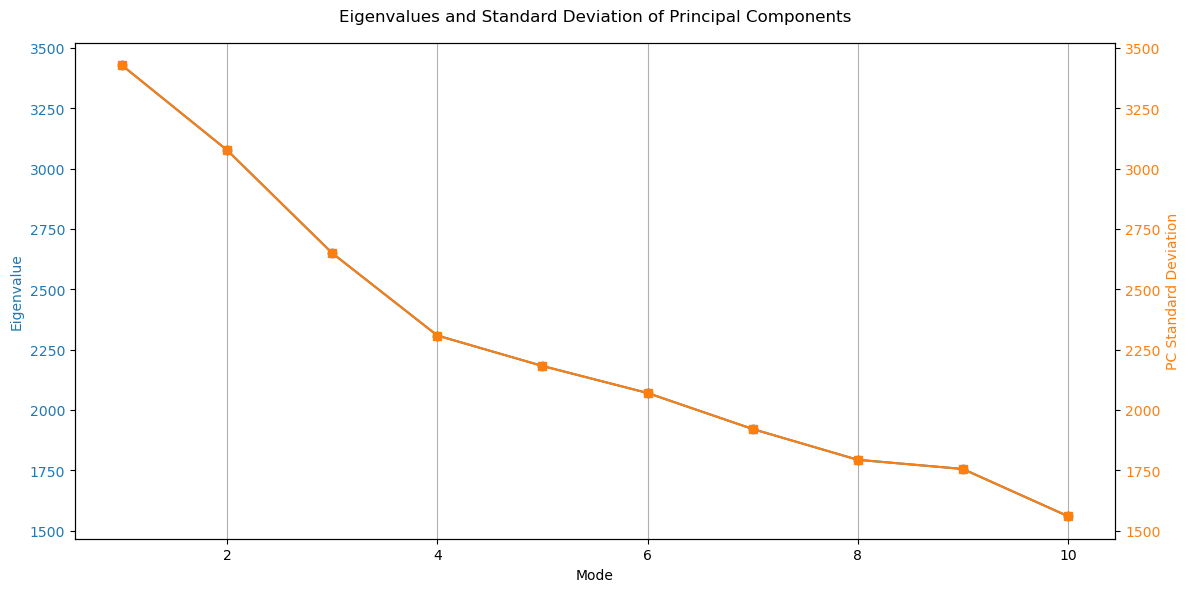

/tmp/ipykernel_108425/2752369428.py:77: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.dataset.dims['lat'], self.dataset.dims['lon']


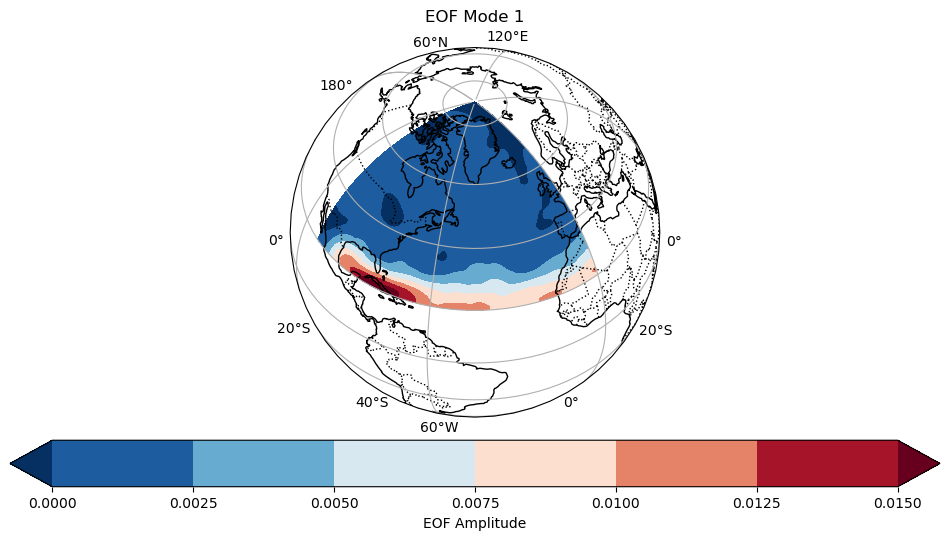

In [24]:
anomalies = EOFer(anos, 'zg')
anomalies.plot_eigenvalues_and_pc_stds()
anomalies.plot_eof(mode=1)

## Detrend

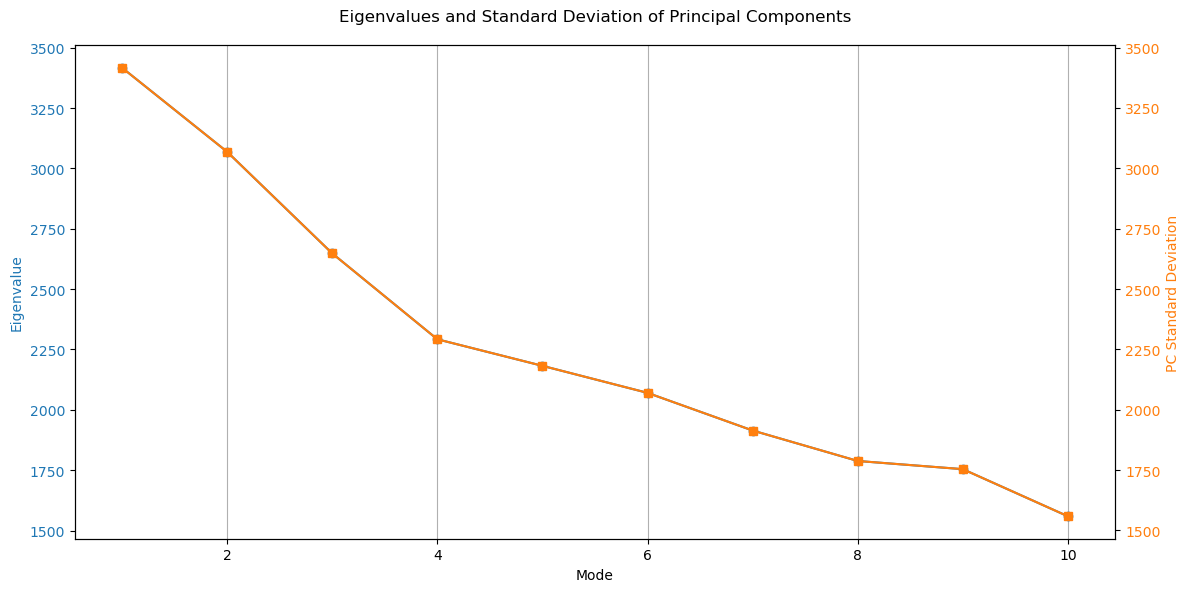

/tmp/ipykernel_108425/2752369428.py:77: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  self.dataset.dims['lat'], self.dataset.dims['lon']


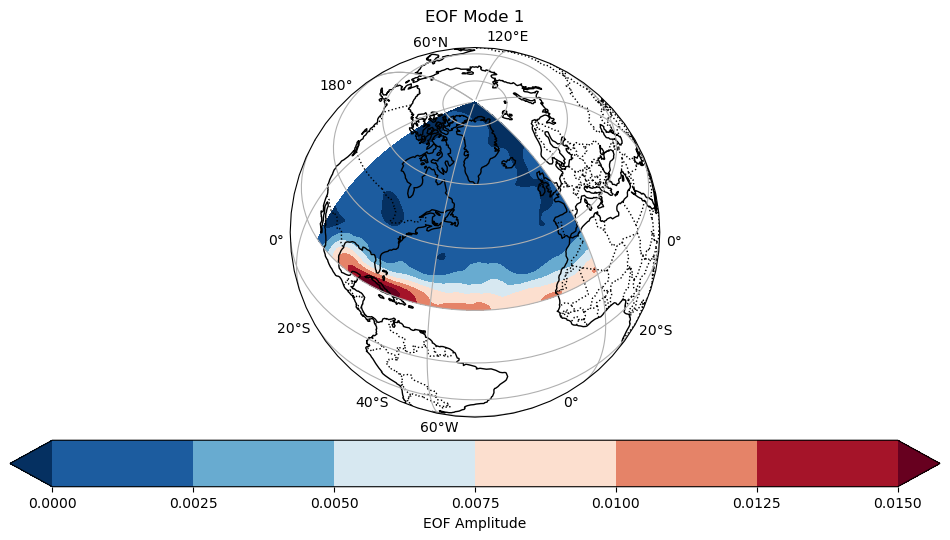

In [25]:
from scipy.signal import detrend

# Detrend the 'zg' variable along the time dimension
detrended = anos.copy()
dett = detrend(anos['zg'].values, axis=0)
type(dett)
dett.shape

detrended['zg'].values = dett

detrendedd = EOFer(detrended, 'zg')
detrendedd.plot_eigenvalues_and_pc_stds()
detrendedd.plot_eof(mode=1)